In [1]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.training_controller import Trainer
from src.helper_funcs import conv_block, ResidualBlock, calculate_accuracy, visualize_incorrectly_classified_images
from datetime import datetime

print(torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.device_count(), torch.cuda.get_device_name(0))

D:\Anaconda\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\Anaconda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


True 0 1 NVIDIA GeForce GTX 1060 6GB


## Model 

In [2]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.res1 = ResidualBlock([3,8,16], True)
        self.res2 = ResidualBlock([16, 32, 64], True)
        self.res3 = ResidualBlock([64,128, 256], True)     
        self.res4 = ResidualBlock([256,512, 1024], True)

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, 6)
                                       )

    def forward(self, x):

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
 
        x = self.classifier(x)

        return x

In [3]:
my_transforms = transforms.Compose(
    [
        transforms.CenterCrop(size=(100, 100)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        # transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(1), saturation=(0.5, 1.5), hue=(-0.1, 0.1)),
        transforms.ToTensor()
    ])

my_eval_transforms = transforms.Compose(
    [
        transforms.CenterCrop(size=(100, 100)),
        transforms.ToTensor(),
    ])

model = ResNet()
batch_size = 32
max_lr = 0.0006

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=max_lr,
                      weight_decay=1e-4,
                      momentum=0.9
                     )

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, step_size_up = 20, base_lr=0.0001, max_lr=max_lr)


In [4]:
my_trainer = Trainer(model, 'Geo_data/seg_train', 'Geo_data/seg_test', 'Geo_data/seg_pred',
                  transform=my_transforms, eval_transform=my_eval_transforms, gradient_clipping=True, batch_size=32, loss_function=criterion,
                  optimizer=optimizer, scheduler= scheduler, epochs=30)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Geo_data/seg_train'

In [24]:

my_trainer.train()

Training on  NVIDIA GeForce GTX 1060 6GB
Started training at: 14:32:05
Epoch [0]: loss: 0.3158459010998589, time finished: 2022-08-05 14:32:47.875371, learning rate: 0.005705000000000001, train acc 91 %
Epoch [1]: loss: 0.3133143151946926, time finished: 2022-08-05 14:33:29.962072, learning rate: 0.0054100000000000025, train acc 87 %
Epoch [2]: loss: 0.2970666065642394, time finished: 2022-08-05 14:34:11.676121, learning rate: 0.005114999999999998, train acc 92 %
Epoch [3]: loss: 0.2816469315906185, time finished: 2022-08-05 14:34:52.938539, learning rate: 0.004819999999999999, train acc 93 %
Epoch [4]: loss: 0.25955223456737936, time finished: 2022-08-05 14:35:35.248689, learning rate: 0.004525, train acc 93 %
Epoch [5]: loss: 0.24875436973564988, time finished: 2022-08-05 14:36:17.115751, learning rate: 0.004230000000000001, train acc 94 %
Epoch [6]: loss: 0.24467716315137497, time finished: 2022-08-05 14:36:58.202051, learning rate: 0.003935000000000002, train acc 93 %
Epoch [7]: lo

KeyboardInterrupt: 

In [26]:
acc = calculate_accuracy(my_trainer._testloader, my_trainer.getModel())
acc

75

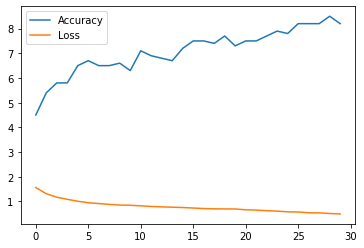

In [22]:
my_trainer.visualize_results()

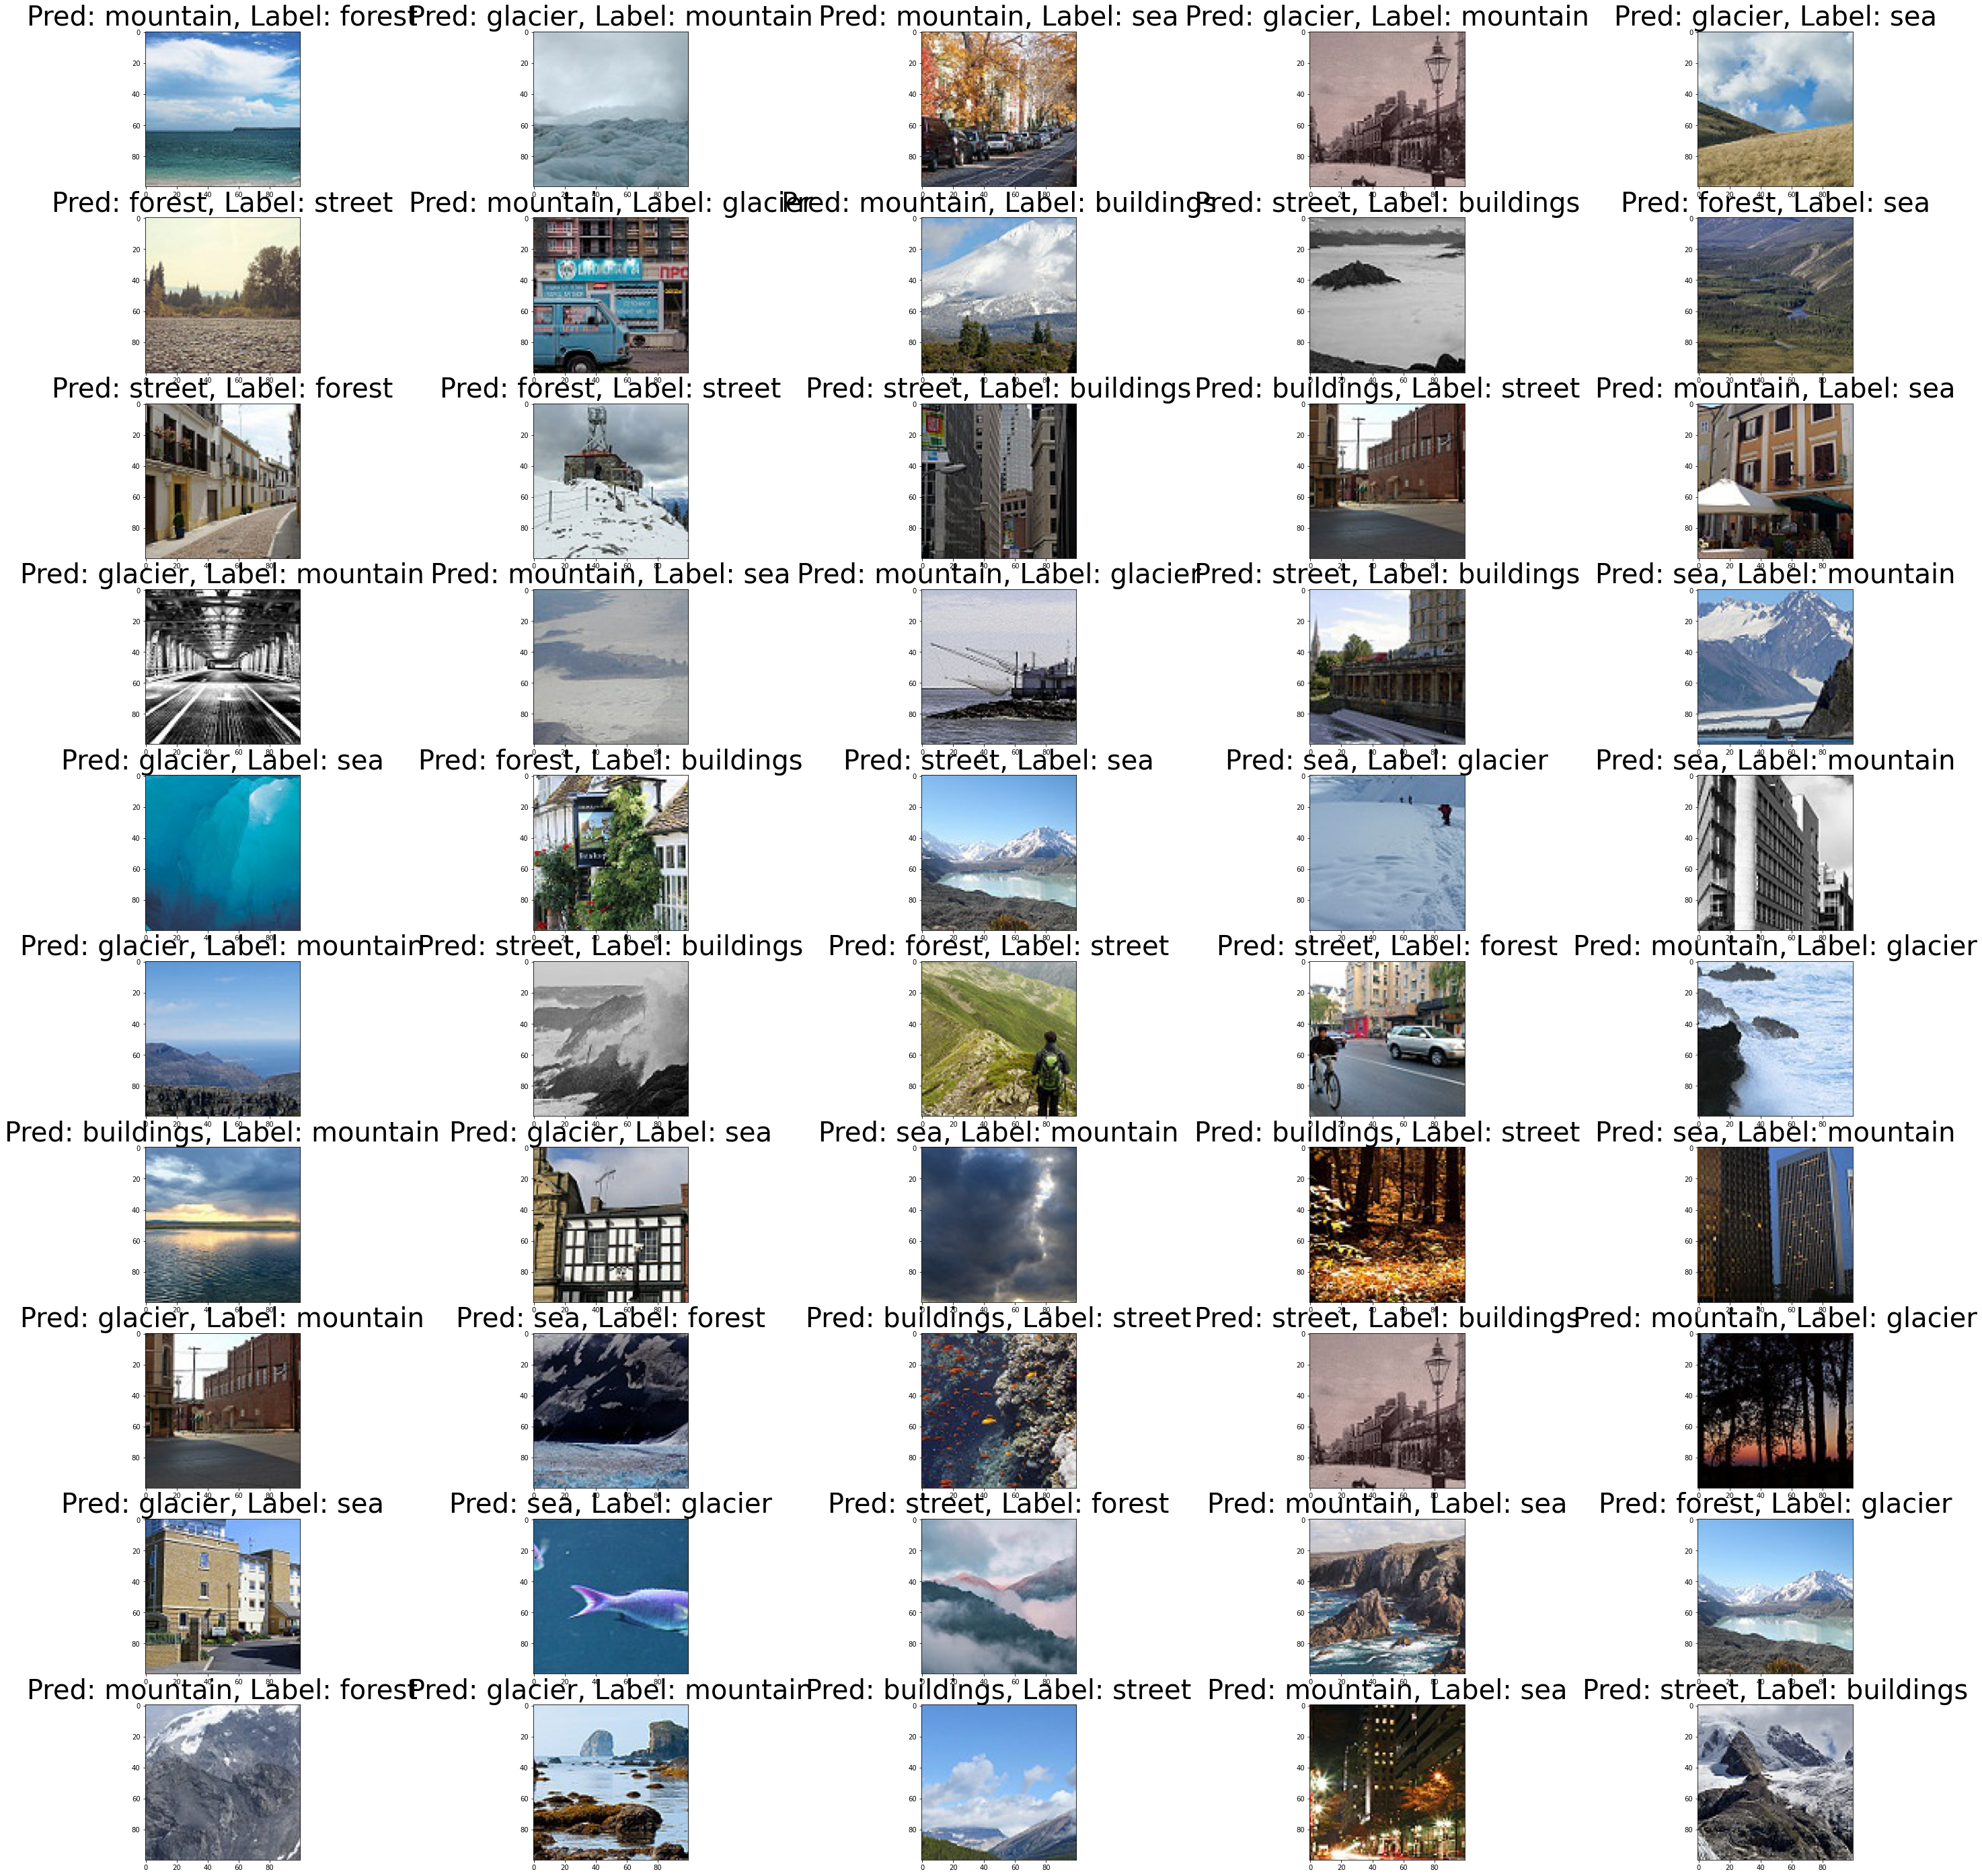

In [28]:
m = torch.jit.script(my_trainer.getModel())

torch.jit.save(m, "script.pt")
#model = torch.load("model") 
visualize_incorrectly_classified_images(my_trainer._testloader, my_trainer.getModel(), 50)

In [13]:
acc

78

In [15]:
torch.save(my_trainer.getModel(), "model")

## Evaluate the model

In [ ]:
model = torch.load("ResNet_4_Blocks_150_Epochs_86_acc")


In [ ]:
print(f'Test set accuracy: {calculate_accuracy()} %, eval set accuracy: {calculate_accuracy_on_eval()}%')

# Test on single image

In [167]:
from PIL import Image

In [168]:
img = Image.open("Geo_data/seg_pred/seg_pred/10004.jpg")
transform = transforms.Compose(
    [
        transforms.RandomCrop((80, 80)),
        transforms.ToTensor(),
    ])

img = transform(img)


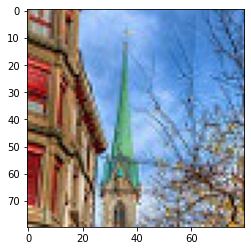

In [169]:
import matplotlib.pyplot as plt
plt.imshow(  img.permute(1, 2, 0)  )


In [170]:
img = torch.unsqueeze(img, dim=0)
img.shape

torch.Size([1, 3, 80, 80])

In [171]:
transform = transforms.Compose([transforms.Resize((80,80))])
img = transform(img)
img = img.to('cuda')

In [172]:
pred_translator = {
    0: "buildings",
    1: "forest",
    2: "glacier",
    3: "mountain",
    4: "sea",
    5: "street",
  
}

outputs = model(img)
_, preds = torch.max(outputs, dim=1)
print(pred_translator[preds.item()])

street
